#### https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import math

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
## Import Utility Functions ...
from utils import series_to_supervised, compute_rmse

In [3]:
# load dataset
dataset = pd.read_csv('economic_indicators.csv')
dataset.set_index('date', inplace = True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 1986 Q1 to 2019 Q3
Data columns (total 10 columns):
gdp_change         135 non-null float64
unrate             135 non-null float64
nfjobs             135 non-null int64
treas10yr          135 non-null float64
treas3mo           135 non-null float64
treas10yr3mo       135 non-null float64
fedintrate         135 non-null float64
libor3mo           135 non-null float64
personincomechg    135 non-null float64
corpprofitchg      135 non-null float64
dtypes: float64(9), int64(1)
memory usage: 11.6+ KB


Text(0.5, 1.0, 'GDP Chnage')

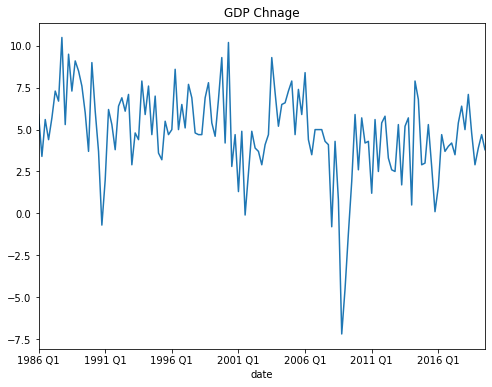

In [4]:
dataset['gdp_change'].plot(figsize=(8,6))
plt.title("GDP Chnage")

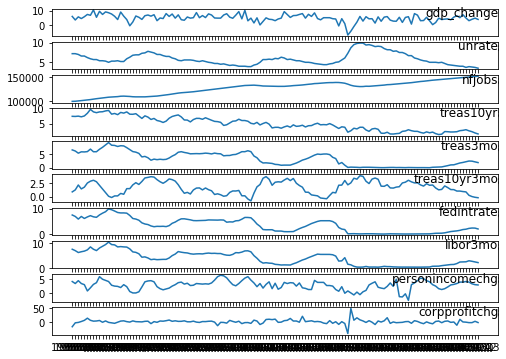

In [5]:
# plot each column
i = 1
plt.figure(figsize=(8,6))
for column in dataset.columns:
    plt.subplot(len(dataset.columns), 1, i)
    plt.plot(dataset.loc[:, column])
    plt.title(column, y=0.5, loc='right')
    i += 1
plt.show()

In [6]:
values = dataset.values

In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
# specify the number of lag hours
n_timesteps = 2  # Quarterly data
# n_timesteps = 12  # Monthly data
n_features = 10

In [9]:
#scaled[0:20,0:5]

In [10]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_timesteps, 1)
print(reframed.shape)
reframed.head()

(133, 30)


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
2,0.740113,0.578125,0.000000,0.724816,0.707476,0.357456,0.757669,0.714835,0.750000,0.270867,...,0.723164,0.546875,0.019072,0.732187,0.578548,0.631579,0.595092,0.584652,0.784091,0.441804
3,0.598870,0.578125,0.004215,0.719902,0.664139,0.436404,0.700409,0.659042,0.670455,0.427127,...,0.655367,0.484375,0.030038,0.705160,0.631636,0.475877,0.699387,0.615648,0.670455,0.479780
4,0.723164,0.546875,0.019072,0.732187,0.578548,0.631579,0.595092,0.584652,0.784091,0.441804,...,0.728814,0.484375,0.042530,0.739558,0.627302,0.546053,0.619632,0.640445,0.625000,0.524898
5,0.655367,0.484375,0.030038,0.705160,0.631636,0.475877,0.699387,0.615648,0.670455,0.479780,...,0.819209,0.421875,0.056566,0.846437,0.640303,0.710526,0.680982,0.690039,0.375000,0.611602
6,0.728814,0.484375,0.042530,0.739558,0.627302,0.546053,0.619632,0.640445,0.625000,0.524898,...,0.785311,0.375000,0.070813,1.000000,0.739978,0.782895,0.731084,0.807824,0.500000,0.526618


In [11]:
# split into train and test sets
values = reframed.values
n_train = int(len(reframed) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

print(train.shape)
print(test.shape)

(106, 30)
(27, 30)


**Next, we need to be more careful in specifying the column for input and output.**

We have 3 * 8 + 8 columns in our framed dataset. We will take 3 * 8 or 24 columns as input for the obs of all features across the previous 3 hours. We will take just the pollution variable as output at the following hour, as follows:

In [12]:
# split into input and outputs
n_obs = n_timesteps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape, len(test_X), test_y.shape)

(106, 20) 106 (106,)
(27, 20) 27 (27,)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(106, 2, 10) (106,) (27, 2, 10) (27,)


In [33]:
# example = 7
# print(train_X[example,:,0:5])
# print(train_y[example,])

In [63]:
# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
# model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 50)                9150      
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 9,201
Trainable params: 9,201
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
%%time
# fit network
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
history = model.fit(train_X, train_y,
                    epochs=1000, batch_size=16,
                    validation_data=(test_X, test_y),
                    verbose=0, shuffle=False)#, callbacks=[es, mc])

Wall time: 1min 18s


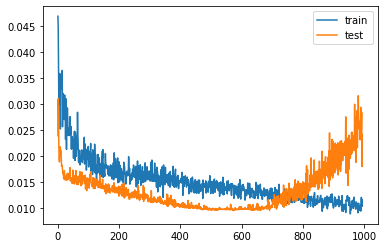

In [65]:
# plot history
plt.plot(history.history['loss'][5:], label='train')
plt.plot(history.history['val_loss'][5:], label='test')
plt.legend()
plt.show()

In [66]:
(inv_y_test, inv_yhat_test, _) = compute_rmse(test_X, test_y, scaler, model, n_timesteps, n_features, dtype="Test")
(inv_y_train, inv_yhat_train, _) = compute_rmse(train_X, train_y, scaler, model, n_timesteps, n_features)

Test RMSE: 2.8
Train RMSE: 1.7


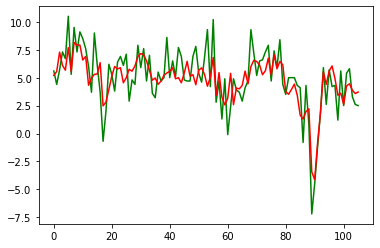

In [67]:
plt.plot(inv_y_train, color='green')
plt.plot(inv_yhat_train, color='red')
plt.show()

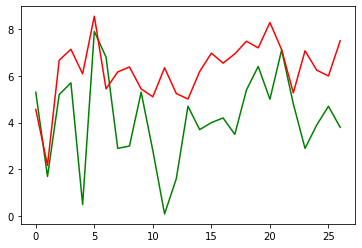

In [68]:
plt.plot(inv_y_test, color='green')
plt.plot(inv_yhat_test, color='red')
plt.show()